# How does the gain parameter affect Gabor bandwidth?

In [638]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        # print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
        return weights_, metrics_
    else:
        raise ValueError('No such file')

def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

config_ = dict(
    # data config
    num_dimensions=40, xi1=2, xi2=1,
    # num_dimensions=100, xi1=12, xi2=6,
    dataset_cls=datasets.NonlinearGPDataset,
    batch_size=1000,
    support=(-1, 1), # defunct
    class_proportion=0.5,
    # model config
    model_cls=models.SimpleNet,
    num_hiddens=40,
    # num_hiddens=100,
    activation='relu',
    use_bias=False,
    sampler_cls=samplers.EpochSampler,
    init_fn=models.xavier_normal_init,
    init_scale=1.,
    # learning config
    # num_epochs=5000,
    num_epochs=5000,
    evaluation_interval=10,
    optimizer_fn=optax.sgd,
    learning_rate=1.,
    # learning_rate=0.05,
    # experiment config
    seed=0,
    save_=True,
    wandb_=False,
)

from scipy.optimize import curve_fit
def gabor_real(c, b, a, x0, k0, x):
    n = len(x)
    d = np.minimum(x-x0, n - (x-x0))
    return c * np.cos(k0 * d) * np.exp(-d ** 2 / a ** 2) + b

def fit(weights, inits):
    K, n = weights.shape
    p, var = np.zeros((K, 4)), np.zeros((K, 4))
    
    for k in range(K):    
        init = inits[k]
        x = np.arange(n)
        y = weights[k]
        try:
            p_, cov = curve_fit(gabor_real, x, y, p0=init, bounds=([-1, -1, 0, -np.inf, -2], [1, 1, np.inf, np.inf, 2]))
            p[k] = p_
            var[k] = np.diag(cov)
        except Exception:
            p[k] = var[k] = np.nan
    
    return p, var

In [639]:
GAIN_SWEEP = np.logspace(-2, 1, 1000)
# GAIN_SWEEP = np.linspace(0.01, 10, 100)

Already simulated


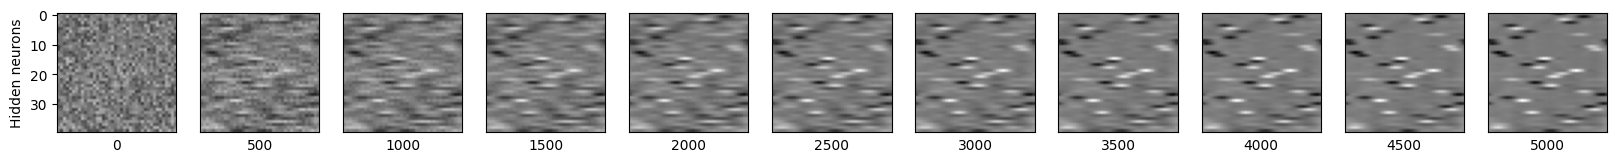

In [640]:
# high gain
config = config_.copy()
config.update(dict(
    gain = 3. #GAIN_SWEEP[-1] # 10
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights[::50], num_cols=11, evaluation_interval=50*10, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

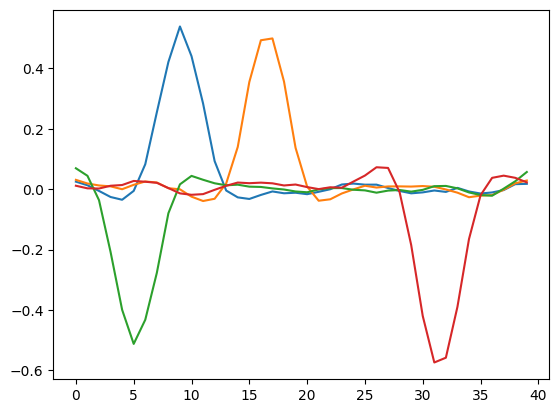

In [644]:
plt.plot( weights[-1,:4].T )

In [449]:
# sweep across gains
all_weights = np.zeros((len(GAIN_SWEEP), 40))
from tqdm import tqdm
for i in tqdm(range(len(GAIN_SWEEP))):
    config = config_.copy()
    config.update(dict(
        gain = GAIN_SWEEP[i] # 10
    ))
    
    try:
        weights, _ = load(**config)
    except Exception:
        print(f"Something weird happend with g={GAIN_SWEEP[i]}")
        continue
    all_weights[i] = weights[-1,0]

 22%|██▏       | 221/1000 [00:00<00:02, 366.63it/s]

Something weird happend with g=0.027633852900531698
Something weird happend with g=0.027825594022071243
Something weird happend with g=0.028018665564591955
Something weird happend with g=0.02821307675939472
Something weird happend with g=0.028408836901833042
Something weird happend with g=0.02860595535175742
Something weird happend with g=0.028804441533962964
Something weird happend with g=0.029004304938639917
Something weird happend with g=0.029205555121827466
Something weird happend with g=0.029408201705870638
Something weird happend with g=0.0356904934567523
Something weird happend with g=0.03593813663804628
Something weird happend with g=0.0361874981241128
Something weird happend with g=0.03643858983763545


100%|██████████| 1000/1000 [00:02<00:00, 363.04it/s]


In [ ]:
p, num = np.zeros((len(GAIN_SWEEP), 4)), np.zeros((len(GAIN_SWEEP), 4))
param, var = fit(weights[-1])
p[i] = np.array([ np.mean(np.abs(p_[var_ < 0.2])) for (p_, var_) in zip(param.T, var.T) ])
num[i] = np.array([ np.sum(var_ < 0.2) for var_ in var.T ])

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

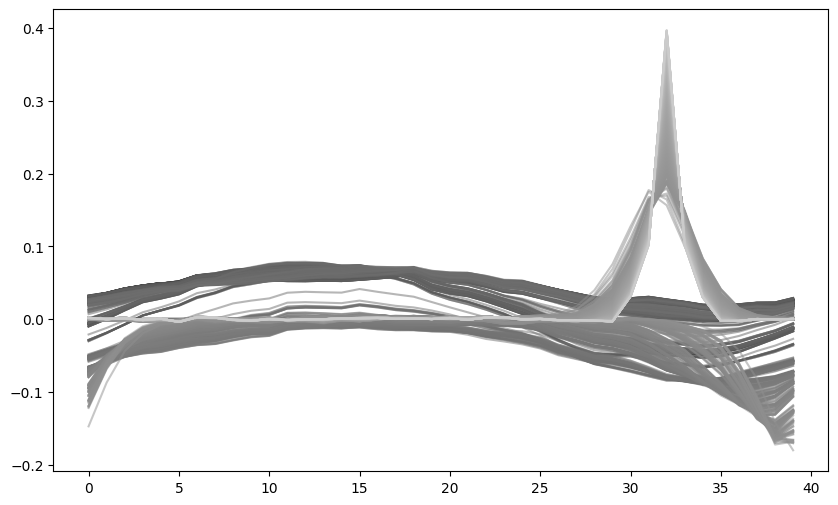

In [450]:
plot_rf_evolution(all_weights.reshape(all_weights.shape[0], 1, -1), num_cols=1, num_rows=1, figsize=(10, 6))

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

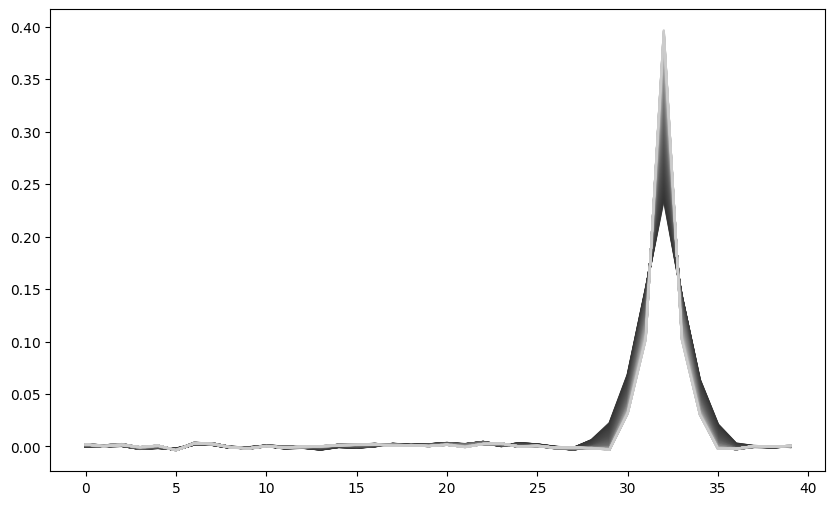

In [464]:
# w_ = all_weights[(0.2 < GAIN_SWEEP) * (GAIN_SWEEP < 0.6)]
# w_ = all_weights[(0.6 <= GAIN_SWEEP) * (GAIN_SWEEP < 1.0)]
w_ = all_weights[(1.0 <= GAIN_SWEEP) * (GAIN_SWEEP < 10.0)]
w_ = w_ * (2 * (w_.max(axis=1) > -w_.min(axis=1)) - 1).reshape(-1, 1)
plot_rf_evolution(w_.reshape(w_.shape[0], 1, -1), num_cols=1, num_rows=1, figsize=(10, 6))

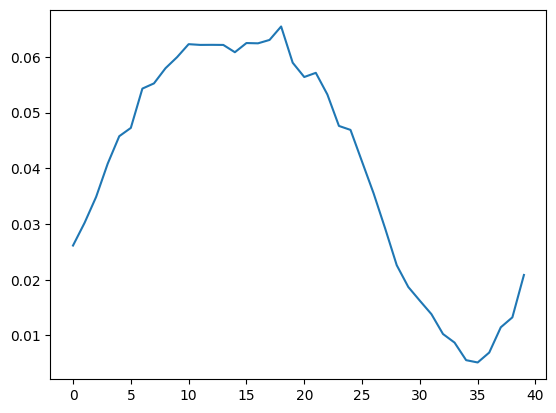

In [396]:
plt.plot( all_weights[0] )

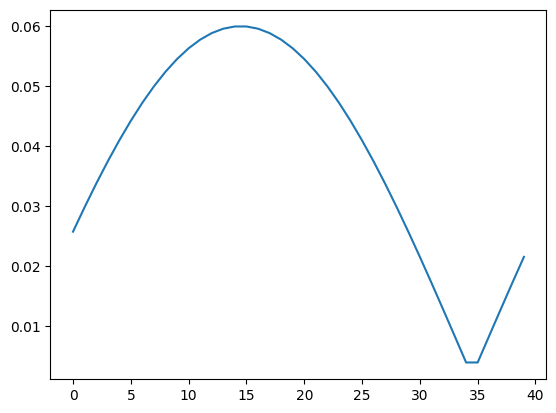

In [438]:
wrap_around = lambda x:np.minimum(x, 40 - x)
gabor_real = lambda x, c, b, a, x0, k0: c * np.cos(k0 * wrap_around(x-x0)) * np.exp(-wrap_around(x-x0) ** 2 / a ** 2) + b
# plt.plot( gabor_real(np.arange(40), -0.0689, 0.055, 6.0, 33.5, 0.05) )
# plt.plot( gabor_real(np.arange(40), -0.0489, 0.045, 100.0, 33.5, 0.15) )
# plt.plot( gabor_real(np.arange(40), 0.03999997, 0.026315, 100.0, 14.0, 0.11206) )
plt.plot( gabor_real(np.arange(40), 0.060000, 0.0, 100.0, 14.5, 0.077) )
# plt.plot( gabor_real(np.arange(40), 0.345, 0, 1, 32, 0.15) )

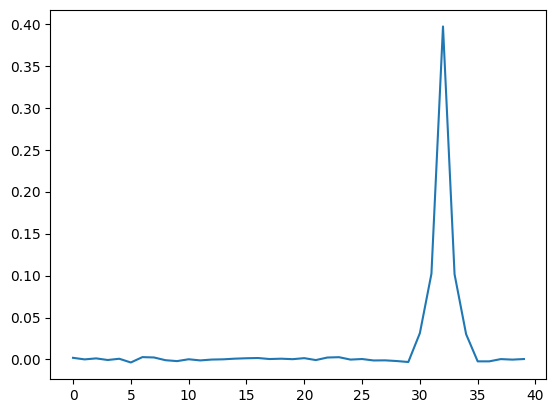

In [442]:
weights[-1,0] 

In [567]:
GAIN_SWEEP = np.logspace(-2, 1, 1000)
params = ['c', 'b', 'a', 'x0', 'k0']
opt = np.load('../results/cluster/gain_analysis/opt_params.npy')
err = np.load('../results/cluster/gain_analysis/errs.npy') * np.sqrt(40)
err_ = np.array([ np.linalg.norm( all_weights[i] - gabor_real(np.arange(40), *opt[i]) ) for i in range(len(GAIN_SWEEP)) ])

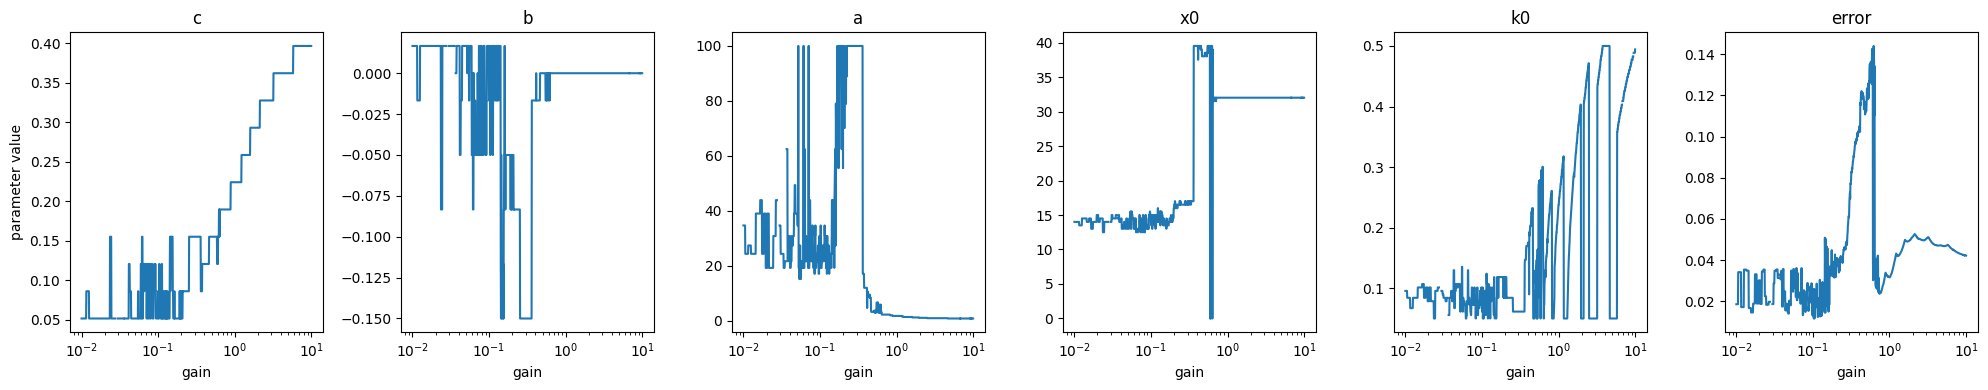

In [569]:
fig, axs = plt.subplots(1, 6, figsize=(20, 4), sharex=True)
for i, ax in enumerate(axs[:-1]):
    if i == 0:
        ax.plot( GAIN_SWEEP, np.abs(opt[:,i]) )
    else:
        ax.plot( GAIN_SWEEP, opt[:,i] )
    ax.set_title(params[i])
    ax.set_xscale('log')
    ax.set_xlabel('gain')
    if i  == 0:
        ax.set_ylabel('parameter value')
axs[-1].plot( GAIN_SWEEP, err )
axs[-1].set_title('error')
axs[-1].set_xscale('log')
axs[-1].set_xlabel('gain')
fig.tight_layout()

Text(0.5, 1.0, 'gain=10.0000, err=0.0067')

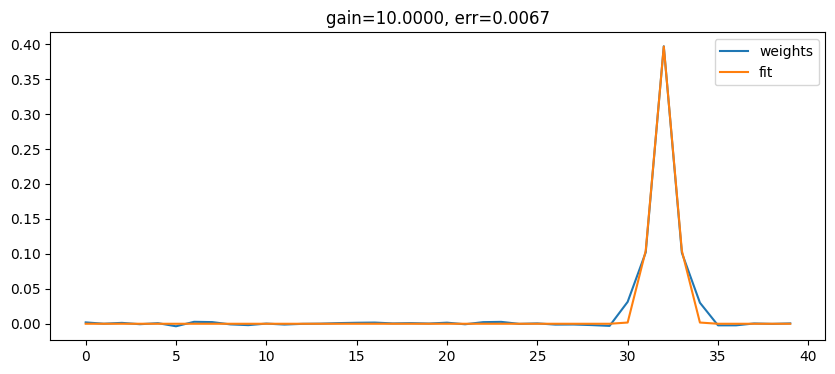

In [566]:
t = -1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot( all_weights[t], label='weights' )
ax.plot( gabor_real(np.arange(40), *opt[t]), label='fit' )
ax.legend()
ax.set_title(f'gain={GAIN_SWEEP[t]:.4f}, err={err[t]:.4f}')

In [540]:
def gabor_real(x, c, b, a, x0, k0):
    n = len(x)
    d = np.minimum(x-x0, n - (x-x0))
    return c * np.cos(k0 * d) * np.exp(-d ** 2 / a ** 2) + b

def fit(weights, inits):
    K, n = weights.shape
    p, var = np.zeros((K, 5)), np.zeros((K, 5))
    
    for k in range(K):    
        init = inits[k]
        x = np.arange(n)
        y = weights[k]
        try:
            p_, cov = curve_fit(gabor_real, x, y, p0=init, bounds=([-1, -1, 0, 0, 0], [1, 1, np.inf, n, 2]))
            p[k] = p_
            var[k] = np.diag(cov)
        except Exception as e:
            print(e)
            p[k] = var[k] = np.nan
    
    return p, var

In [541]:
# refine estimates with curvefit
p, var = fit(all_weights, opt)
err_p = np.array([ np.linalg.norm( all_weights[i] - gabor_real(np.arange(40), *p[i]) ) for i in range(len(GAIN_SWEEP)) ])

`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.
`x0` is infeasible.


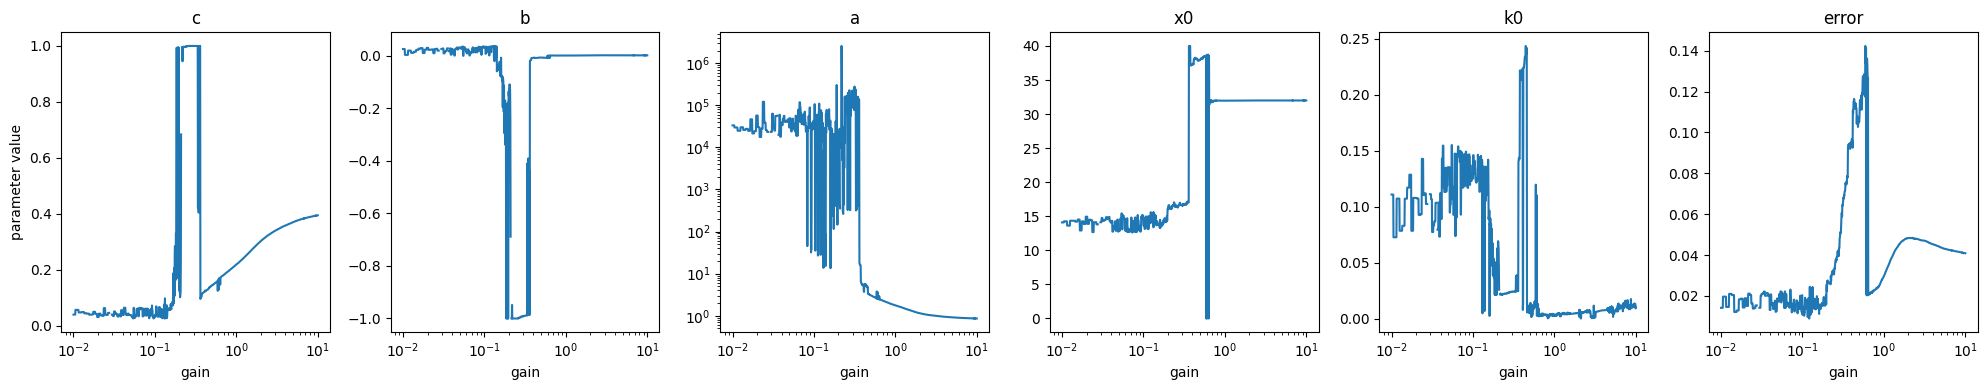

In [570]:
fig, axs = plt.subplots(1, 6, figsize=(20, 4), sharex=True)
for i, ax in enumerate(axs[:-1]):
    if i == 0:
        ax.plot( GAIN_SWEEP, np.abs(p[:,i]) )
    else:
        ax.plot( GAIN_SWEEP, p[:,i] )
    ax.set_title(params[i])
    ax.set_xscale('log')
    ax.set_xlabel('gain')
    if i  == 0:
        ax.set_ylabel('parameter value')
    if i == 2:
        ax.set_yscale('log')
axs[-1].plot( GAIN_SWEEP, err_p )
axs[-1].set_title('error')
axs[-1].set_xscale('log')
axs[-1].set_xlabel('gain')
fig.tight_layout()

In [571]:
p[:,1][~np.isnan(p[:,1])].argmin()

452

[ 9.96193175e-01 -9.99999871e-01  2.65553788e+02  1.64987941e+01
  2.11245980e-02]


Text(0.5, 1.0, 'gain=0.2277, err=0.0391')

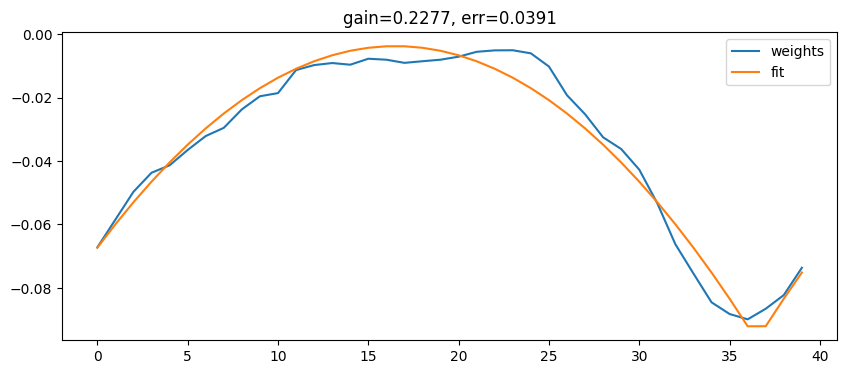

In [572]:
t = 452 # 429
print(p[t])
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot( all_weights[t], label='weights' )
ax.plot( gabor_real(np.arange(40), *p[t]), label='fit' )
ax.legend()
ax.set_title(f'gain={GAIN_SWEEP[t]:.4f}, err={err[t]:.4f}')

Text(0.5, 1.0, 'k0')

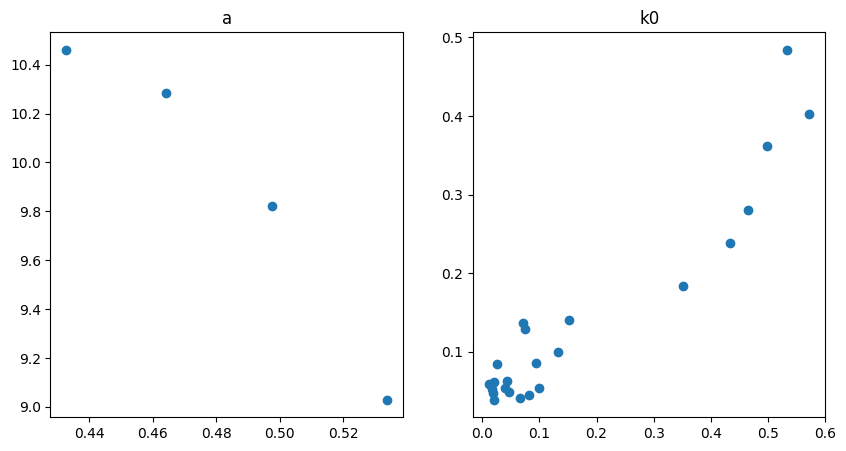

In [244]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
_ = ax1.plot(GAIN_SWEEP, p[:,1], 'o')
ax1.set_title('a')
_ = ax2.plot(GAIN_SWEEP, p[:,3], 'o')
ax2.set_title('k0')

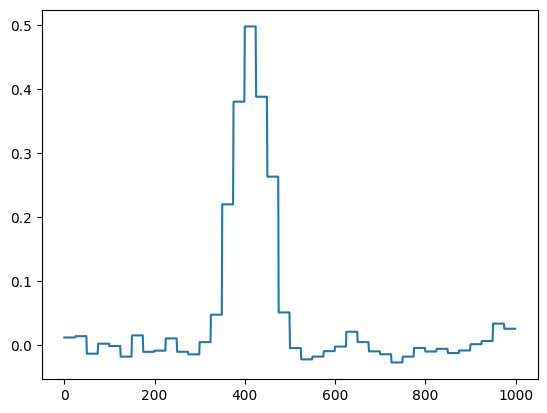

In [148]:
plt.plot( np.tile(weights[-1,1], (25,1)).T.flatten() )

In [149]:
x0_init = np.argmax( np.abs(weights[-1,1]) )
p_, cov = curve_fit(gabor_real, np.linspace(0,40,1000), np.tile(weights[-1,1], (25,1)).T.flatten(), p0=[0.5, 1., x0_init, 1])
print(p_)
print(cov)

[ 0.47580279  3.21693687 16.56122983 -0.40491555]
[[ 1.01154558e-05 -7.08904337e-05  3.07314068e-12 -1.84258551e-06]
 [-7.08904337e-05  2.92485498e-03 -1.14601394e-11 -1.18429709e-04]
 [ 3.07314068e-12 -1.14601394e-11  1.46005155e-04 -2.75402523e-12]
 [-1.84258551e-06 -1.18429709e-04 -2.75402523e-12  2.05661567e-05]]


In [100]:
x0_init = np.argmax( np.abs(weights[-1,1]) )
p_, cov = curve_fit(gabor_real, np.arange(40), weights[-1,1], p0=[0.5, 1., x0_init, 1])
print(p_)
print(cov)

[ 0.48329021 -3.18066217 15.99279888 -5.87204073]
[[ 1.19520882e-04  8.15452419e-04 -3.76033453e-06  2.13915416e-05]
 [ 8.15452419e-04  3.20916160e-02 -9.73785452e-05 -1.30469722e-03]
 [-3.76033453e-06 -9.73785452e-05  2.84711047e-05  7.38308705e-06]
 [ 2.13915416e-05 -1.30469722e-03  7.38308705e-06  2.36383206e-04]]


/Users/leonlufkin/opt/anaconda3/envs/ML/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


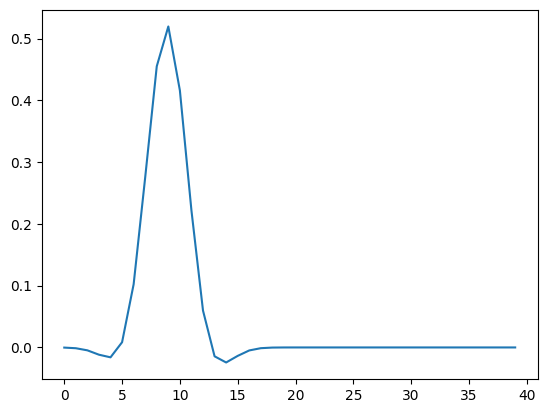

In [61]:
p = fit(weights[-1])
plt.plot( gabor_real(np.arange(40), *p[0][0]) )

/Users/leonlufkin/opt/anaconda3/envs/ML/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


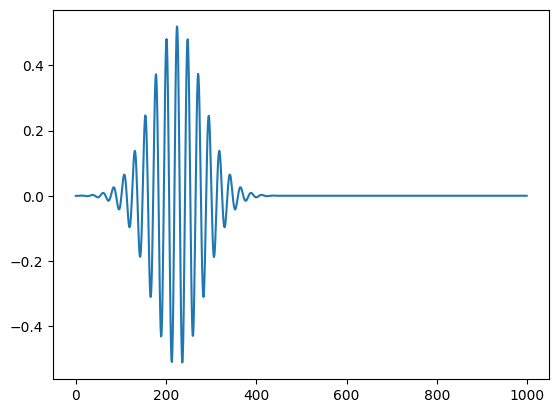

In [65]:
p = fit(weights[-1])
plt.plot( gabor_real(np.linspace(0,40,1000), *p[0][0]) )

Already simulated


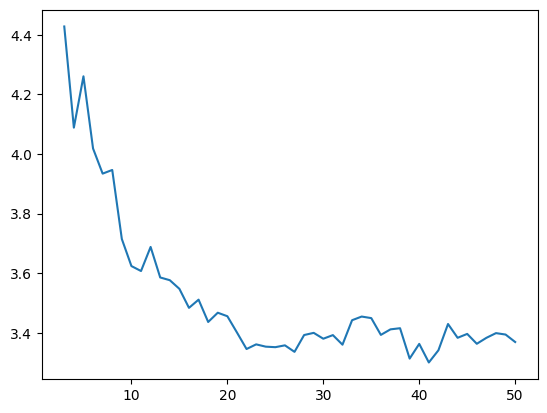

In [112]:
# sweep across time, for a fixed gain
config = config_.copy()
config.update(dict(
    gain = GAIN_SWEEP[-1]
))
weights, _ = simulate_or_load(**config)

metrics = np.zeros((len(weights), 2))
for t in range(len(weights)):
    p, var_p = fit_curve(weights[t])
    x = np.abs(p[var_p < 0.1])
    metrics[t,0] = np.mean(x)
    metrics[t,1] = len(x)
    
_ = plt.plot( metrics[:,0] )

Already simulated


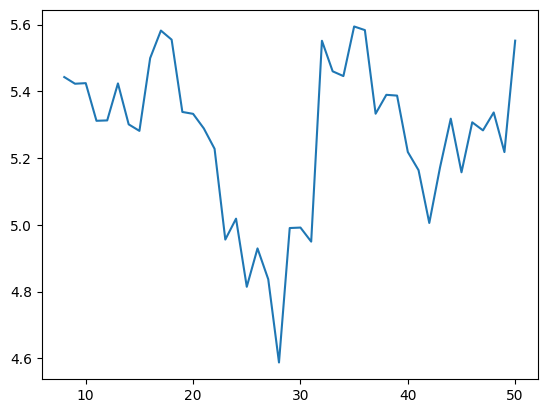

In [115]:
# sweep across time, for a fixed gain
config = config_.copy()
config.update(dict(
    gain = GAIN_SWEEP[4]
))
weights, _ = simulate_or_load(**config)

metrics = np.zeros((len(weights), 2))
for t in range(len(weights)):
    p, var_p = fit_curve(weights[t])
    x = np.abs(p[var_p < 0.1])
    metrics[t,0] = np.mean(x)
    metrics[t,1] = len(x)
    
_ = plt.plot( metrics[:,0] )